# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Mochammad Revi Fikri Wardana
- **Email:** mrevifikri@gmail.com
- **ID Dicoding:** revi_fikri

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


## Import Libraries

In [2]:
import os
import gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Input, Lambda, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from PIL import Image, ImageEnhance
import zipfile
import shutil
import time
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
import tensorflowjs as tfjs

In [3]:
print(tf.__version__)

2.18.0


In [4]:
import pkg_resources

# List of packages to check
packages = [
    'tensorflow',
    'tensorflowjs',
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'opencv-python',
    'Pillow',
    'tqdm',
    'tensorflow-datasets'
]

with open('requirements.txt', 'w') as f:
    for pkg in packages:
        try:
            version = pkg_resources.get_distribution(pkg).version
            f.write(f"{pkg}=={version}\n")
        except Exception as e:
            print(f"Error for {pkg}: {str(e)}")

In [5]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Data Loading

In [6]:
ds = tfds.load('tf_flowers', split='train', as_supervised=True)
dataset_info = tfds.builder('tf_flowers').info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.HBRPOI_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
print("Number of examples:", dataset_info.splits['train'].num_examples)
print("Number of classes:", dataset_info.features['label'].num_classes)
print("Class names:", dataset_info.features['label'].names)

Number of examples: 3670
Number of classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


## Dataset Directory

In [8]:
# Create directories for our dataset
dataset_dir = "flowers_dataset"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "validation")
test_dir = os.path.join(dataset_dir, "test")

In [9]:
# Create directories for each class
class_names = dataset_info.features['label'].names
for split_dir in [train_dir, val_dir, test_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

## Data Extraction, Splitting, and Saving

In [10]:
# Convert dataset to numpy arrays and split into train, validation, and test sets
def extract_and_split_dataset():
    x_data = []
    y_data = []

    print("Processing dataset...")
    for image, label in tqdm(tfds.as_numpy(ds)):
        x_data.append(image)
        y_data.append(label)

    # Split dataset
    x_train_val, x_test, y_train_val, y_test = train_test_split(
        x_data, y_data, test_size=0.15, random_state=42, stratify=y_data
    )

    x_train, x_val, y_train, y_val = train_test_split(
        x_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
    )

    print(f"Train set: {len(x_train)} images")
    print(f"Validation set: {len(x_val)} images")
    print(f"Test set: {len(x_test)} images")

    # Save images to respective directories
    def save_images(images, labels, split_name):
        split_dir = os.path.join(dataset_dir, split_name)
        for img, label in tqdm(zip(images, labels), desc=f"Saving {split_name} images"):
            class_name = class_names[label]
            img_path = os.path.join(split_dir, class_name, f"{time.time()}.jpg")
            Image.fromarray(img).save(img_path)

    save_images(x_train, y_train, "train")
    save_images(x_val, y_val, "validation")
    save_images(x_test, y_test, "test")

In [11]:
# Extract and split the dataset
extract_and_split_dataset()

Processing dataset...


  0%|          | 0/3670 [00:00<?, ?it/s]

Train set: 2495 images
Validation set: 624 images
Test set: 551 images


Saving train images: 0it [00:00, ?it/s]

Saving validation images: 0it [00:00, ?it/s]

Saving test images: 0it [00:00, ?it/s]

## Data Exploration

In [12]:
# Step 2: Data Exploration
def explore_dataset():
    # Count images in each split and class
    counts = {'train': {}, 'validation': {}, 'test': {}}

    for split in counts:
        split_dir = os.path.join(dataset_dir, split)
        total = 0

        for class_name in class_names:
            class_dir = os.path.join(split_dir, class_name)
            count = len(os.listdir(class_dir))
            counts[split][class_name] = count
            total += count

        print(f"{split} set: {total} images")

    # Plot distribution
    plt.figure(figsize=(15, 5))

    for i, split in enumerate(['train', 'validation', 'test']):
        plt.subplot(1, 3, i+1)
        sns.barplot(x=list(counts[split].keys()), y=list(counts[split].values()))
        plt.title(f"{split} set distribution")
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.show()

    # Show sample images
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(train_dir, class_name)
        images = os.listdir(class_dir)[:5]  # Get first 5 images

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=(150, 150))

            plt.subplot(len(class_names), 5, i*5 + j + 1)
            plt.imshow(img)
            plt.axis('off')

            if j == 0:
                plt.ylabel(class_name, rotation=90, size='large')

    plt.tight_layout()
    plt.show()

train set: 2495 images
validation set: 624 images
test set: 551 images


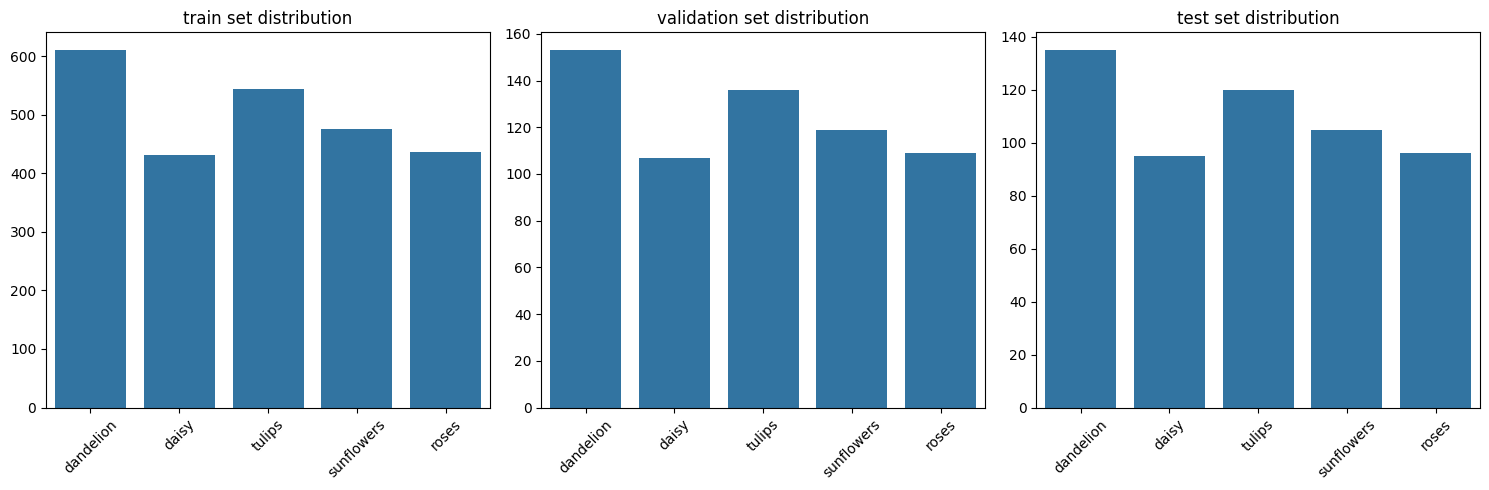

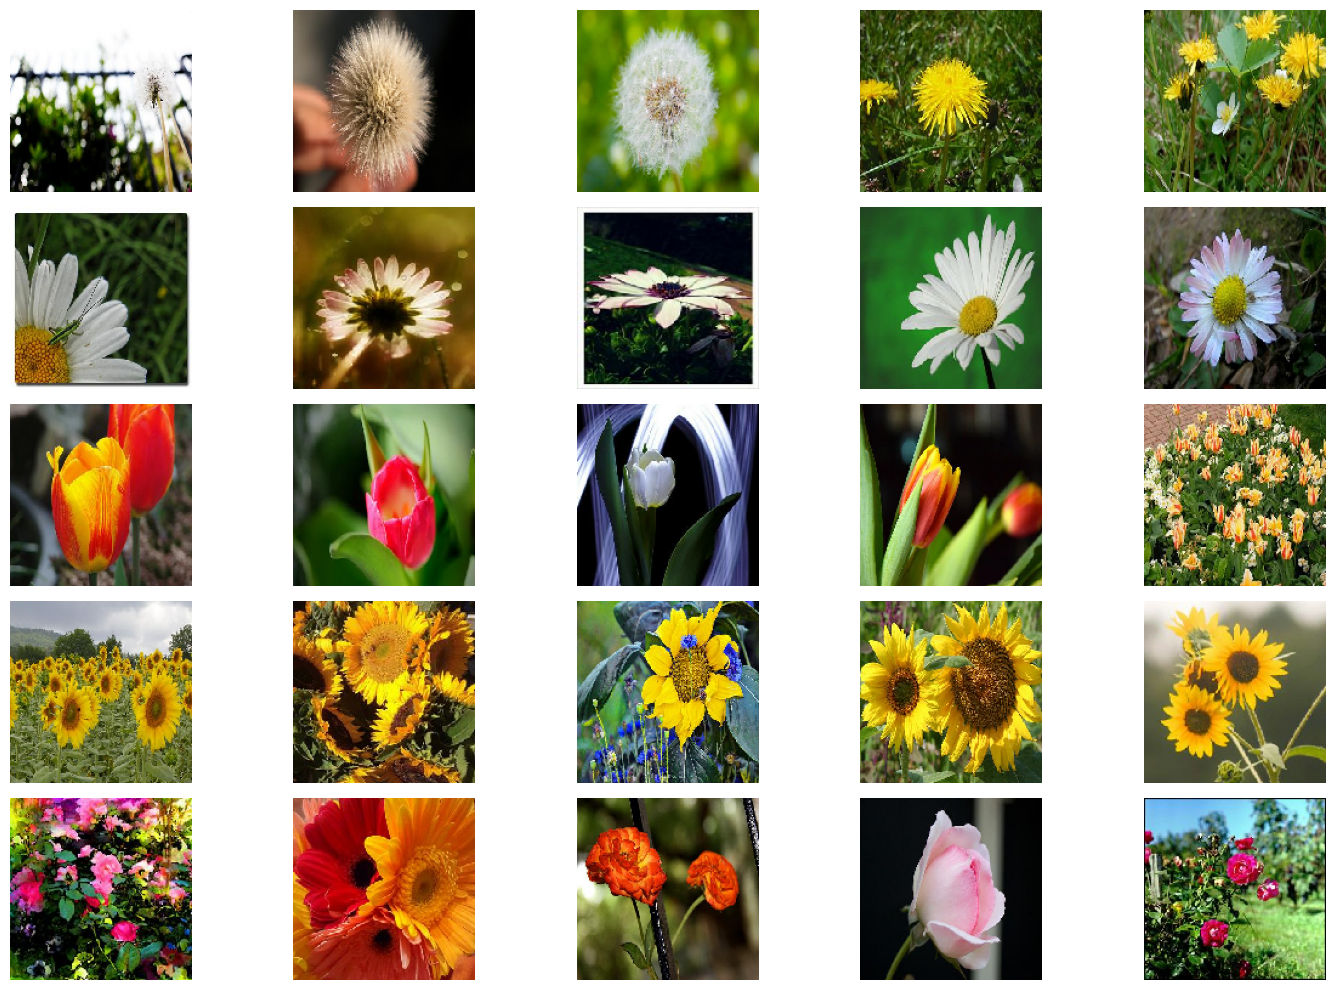

In [13]:
# Explore the dataset
explore_dataset()

## Data Preprocessing and Augemtation

In [14]:
# Step 3: Data Preprocessing and Augmentation Functions
def apply_brightness(img, factor):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)

def apply_contrast(img, factor):
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(factor)

def apply_sharpness(img, factor):
    enhancer = ImageEnhance.Sharpness(img)
    return enhancer.enhance(factor)

def apply_color(img, factor):
    enhancer = ImageEnhance.Color(img)
    return enhancer.enhance(factor)

def random_crop(img, crop_ratio=0.8):
    width, height = img.size
    crop_width = int(width * crop_ratio)
    crop_height = int(height * crop_ratio)

    # Random crop coordinates
    left = random.randint(0, width - crop_width)
    top = random.randint(0, height - crop_height)
    right = left + crop_width
    bottom = top + crop_height

    return img.crop((left, top, right, bottom))

In [15]:
def perform_augmentation(source_dir, target_dir, n_augmented=5):
    # Apply augmentation to images and save them to target directory
    os.makedirs(target_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        source_class_dir = os.path.join(source_dir, class_name)
        target_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)

        # Get list of images in this class
        images = os.listdir(source_class_dir)

        for img_name in tqdm(images, desc=f"Augmenting {class_name}"):
            img_path = os.path.join(source_class_dir, img_name)

            try:
                # Open image
                img = Image.open(img_path).convert('RGB')

                # Copy original image
                img.save(os.path.join(target_class_dir, f"orig_{img_name}"))

                # Generate augmented versions
                for i in range(n_augmented):
                    augmented = img.copy()

                    # Apply random transformations
                    if random.random() > 0.5:
                        # Random rotation
                        angle = random.uniform(-30, 30)
                        augmented = augmented.rotate(angle)

                    if random.random() > 0.5:
                        # Random crop
                        augmented = random_crop(augmented)

                    if random.random() > 0.5:
                        # Random brightness
                        factor = random.uniform(0.7, 1.3)
                        augmented = apply_brightness(augmented, factor)

                    if random.random() > 0.5:
                        # Random contrast
                        factor = random.uniform(0.7, 1.3)
                        augmented = apply_contrast(augmented, factor)

                    if random.random() > 0.5:
                        # Random sharpness
                        factor = random.uniform(0.7, 1.5)
                        augmented = apply_sharpness(augmented, factor)

                    if random.random() > 0.5:
                        # Random color adjustment
                        factor = random.uniform(0.7, 1.3)
                        augmented = apply_color(augmented, factor)

                    # Resize back to standard size
                    augmented = augmented.resize((224, 224))

                    # Save augmented image
                    augmented.save(os.path.join(target_class_dir, f"aug_{i}_{img_name}"))

            except Exception as e:
                print(f"Error processing {img_path}: {e}")

In [16]:
# Create augmented dataset (we'll only augment the training set)
augmented_train_dir = os.path.join(dataset_dir, "augmented_train")
perform_augmentation(train_dir, augmented_train_dir, n_augmented=3)

Augmenting roses:   0%|          | 0/436 [00:00<?, ?it/s]

Augmenting daisy:   0%|          | 0/431 [00:00<?, ?it/s]

Augmenting dandelion:   0%|          | 0/610 [00:00<?, ?it/s]

Augmenting sunflowers:   0%|          | 0/475 [00:00<?, ?it/s]

Augmenting tulips:   0%|          | 0/543 [00:00<?, ?it/s]

## Data Generators

In [17]:
# Step 4: Set up data generators with image preprocessing
IMG_SIZE = 224  # Standard input size for many models
BATCH_SIZE = 16  # Reduced batch size to prevent memory issues

# Create data generators with preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Pixel normalization
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    preprocessing_function=lambda x: tf.image.random_contrast(x, lower=0.8, upper=1.2)
)

# Less aggressive augmentation for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    augmented_train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 9980 images belonging to 5 classes.
Found 624 images belonging to 5 classes.
Found 551 images belonging to 5 classes.


In [19]:
# Get class indices
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

Class indices: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


## Transfer Learning Model  and Handle Colab Resource Limits

In [20]:
# Step 5: Implement Transfer Learning with a Pre-trained Model
# Define a memory cleanup callback
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

def create_model():
    model = Sequential([
        # First Conv2D block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Second Conv2D block - increase filters
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Third Conv2D block - increase filters
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Fourth Conv2D block - increase filters
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Fifth Conv2D block - increase filters
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Global pooling
        GlobalAveragePooling2D(),

        # Dense layers
        Dense(512, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(len(class_names), activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [21]:
# Set up checkpoint directory
checkpoint_path = "model_checkpoints/best_model.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.makedirs(checkpoint_dir, exist_ok=True)

# Check if a checkpoint exists already
initial_epoch = 0
if os.path.exists(checkpoint_path):
    print("Loading model from checkpoint...")
    model = tf.keras.models.load_model(checkpoint_path)
    # If you know which epoch you stopped at, you can set initial_epoch accordingly
    # For example, if you crashed at epoch 6:
    # initial_epoch = 5  # (last completed epoch)
else:
    print("Creating new model...")
    model = create_model()

# Display model summary
model.summary()

Creating new model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,969,861 (7.51 MB)

 Trainable params: 1,966,853 (7.50 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [22]:
# Define callbacks
callbacks = [
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    TensorBoard(
        log_dir='logs',
        histogram_freq=1,
        write_graph=True
    ),
    MemoryCleanupCallback()  # Add the memory cleanup callback
]

In [23]:
# Print GPU information to check resources
try:
    print("GPU Information:")
    !nvidia-smi
except:
    print("No GPU available or nvidia-smi not accessible")


GPU Information:
Fri Apr 18 09:20:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             29W /   70W |     134MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------

In [24]:
# Train model
EPOCHS = 20

# Clear memory before training
gc.collect()
tf.keras.backend.clear_session()

print("Starting model training...")
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    initial_epoch=initial_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)

Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.3814 - loss: 1.6478
Epoch 1: val_accuracy improved from -inf to 0.55929, saving model to model_checkpoints/best_model.keras
624/624 ━━━━━━━━━━━━━━━━━━━━ 214s 321ms/step - accuracy: 0.3815 - loss: 1.6475 - val_accuracy: 0.5593 - val_loss: 1.1088 - learning_rate: 0.0010
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.5249 - loss: 1.1754
Epoch 2: val_accuracy improved from 0.55929 to 0.63462, saving model to model_checkpoints/best_model.keras
624/624 ━━━━━━━━━━━━━━━━━━━━ 253s 320ms/step - accuracy: 0.5249 - loss: 1.1754 - val_accuracy: 0.6346 - val_loss: 0.9530 - learning_rate: 0.0010
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6145 - loss: 0.9966
Epoch 3: val_accuracy did not improve from 0.63462
624/624 ━━━━━━━━━━━━━━━━━━━━ 193s 306ms/step - accuracy: 0.6145 - loss: 0.9966 - val_accuracy: 0.6202 - val_loss: 1.1109 - learning_rate: 0.0010
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━

In [25]:
# Print GPU information to check resources
try:
    print("GPU Information:")
    !nvidia-smi
except:
    print("No GPU available or nvidia-smi not accessible")


GPU Information:
Fri Apr 18 10:27:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P0             30W /   70W |    2166MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------

## Model Evaluation and Visualization

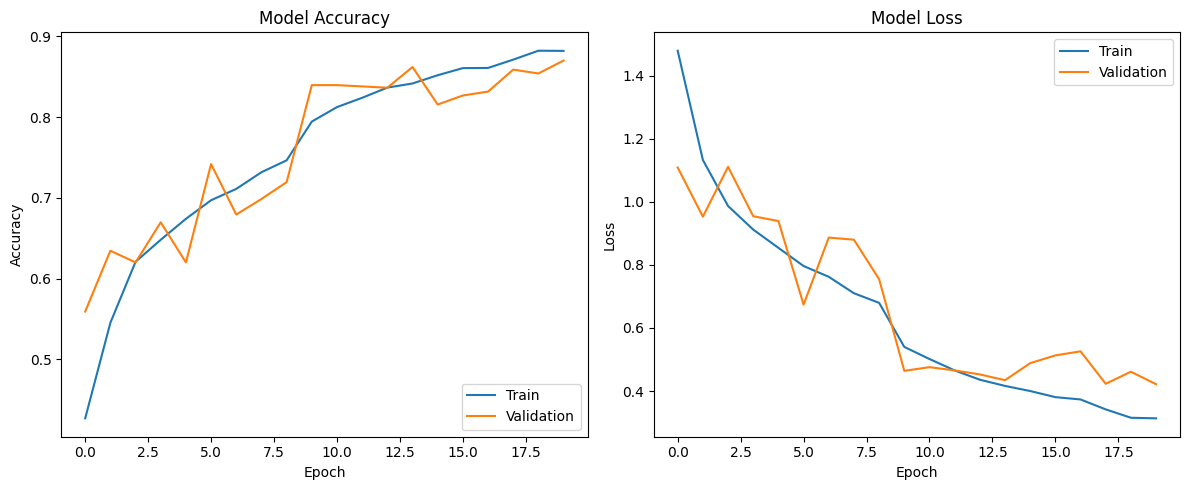

In [26]:
# Combine histories
model_history = {
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss']
}

def plot_training_history(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(model_history)

In [27]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.8962 - loss: 0.3620
Test Accuracy: 0.8820
Test Loss: 0.3537


In [28]:
# Get predictions
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true classes
y_true = test_generator.classes

# Only calculate up to the number of batches that match the dataset size
n_batches = len(test_generator)
y_pred_classes = y_pred_classes[:len(y_true)]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(class_indices.keys())))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step

Classification Report:
              precision    recall  f1-score   support

       daisy       0.89      0.95      0.92        95
   dandelion       0.97      0.84      0.90       135
       roses       0.76      0.81      0.79        96
  sunflowers       0.93      0.96      0.94       105
      tulips       0.85      0.86      0.85       120

    accuracy                           0.88       551
   macro avg       0.88      0.88      0.88       551
weighted avg       0.89      0.88      0.88       551



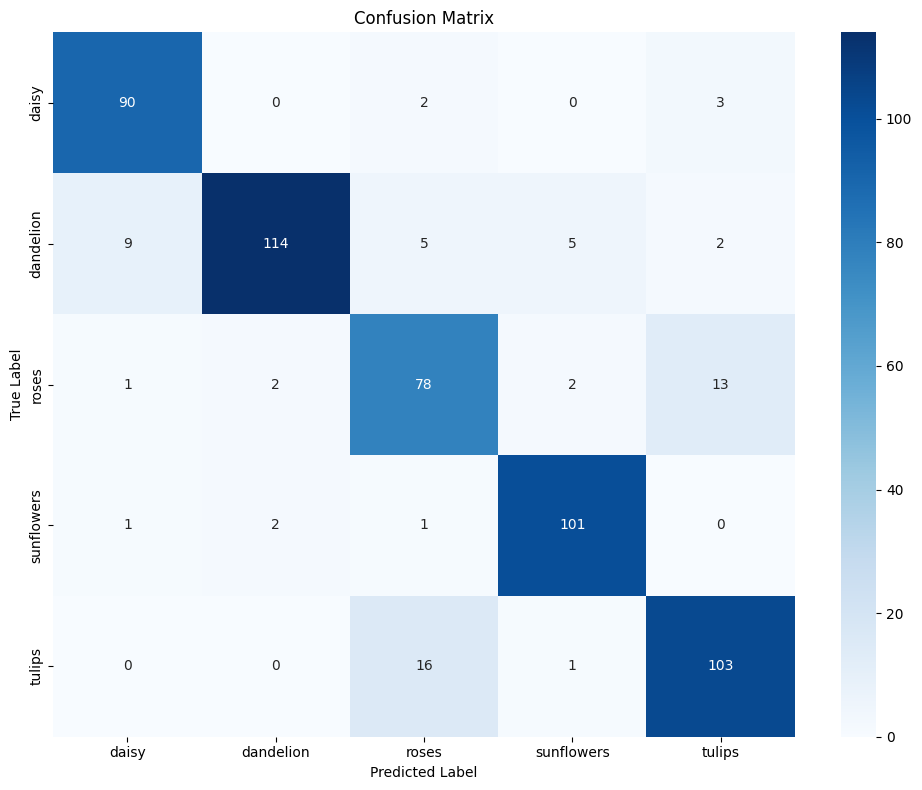

In [35]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


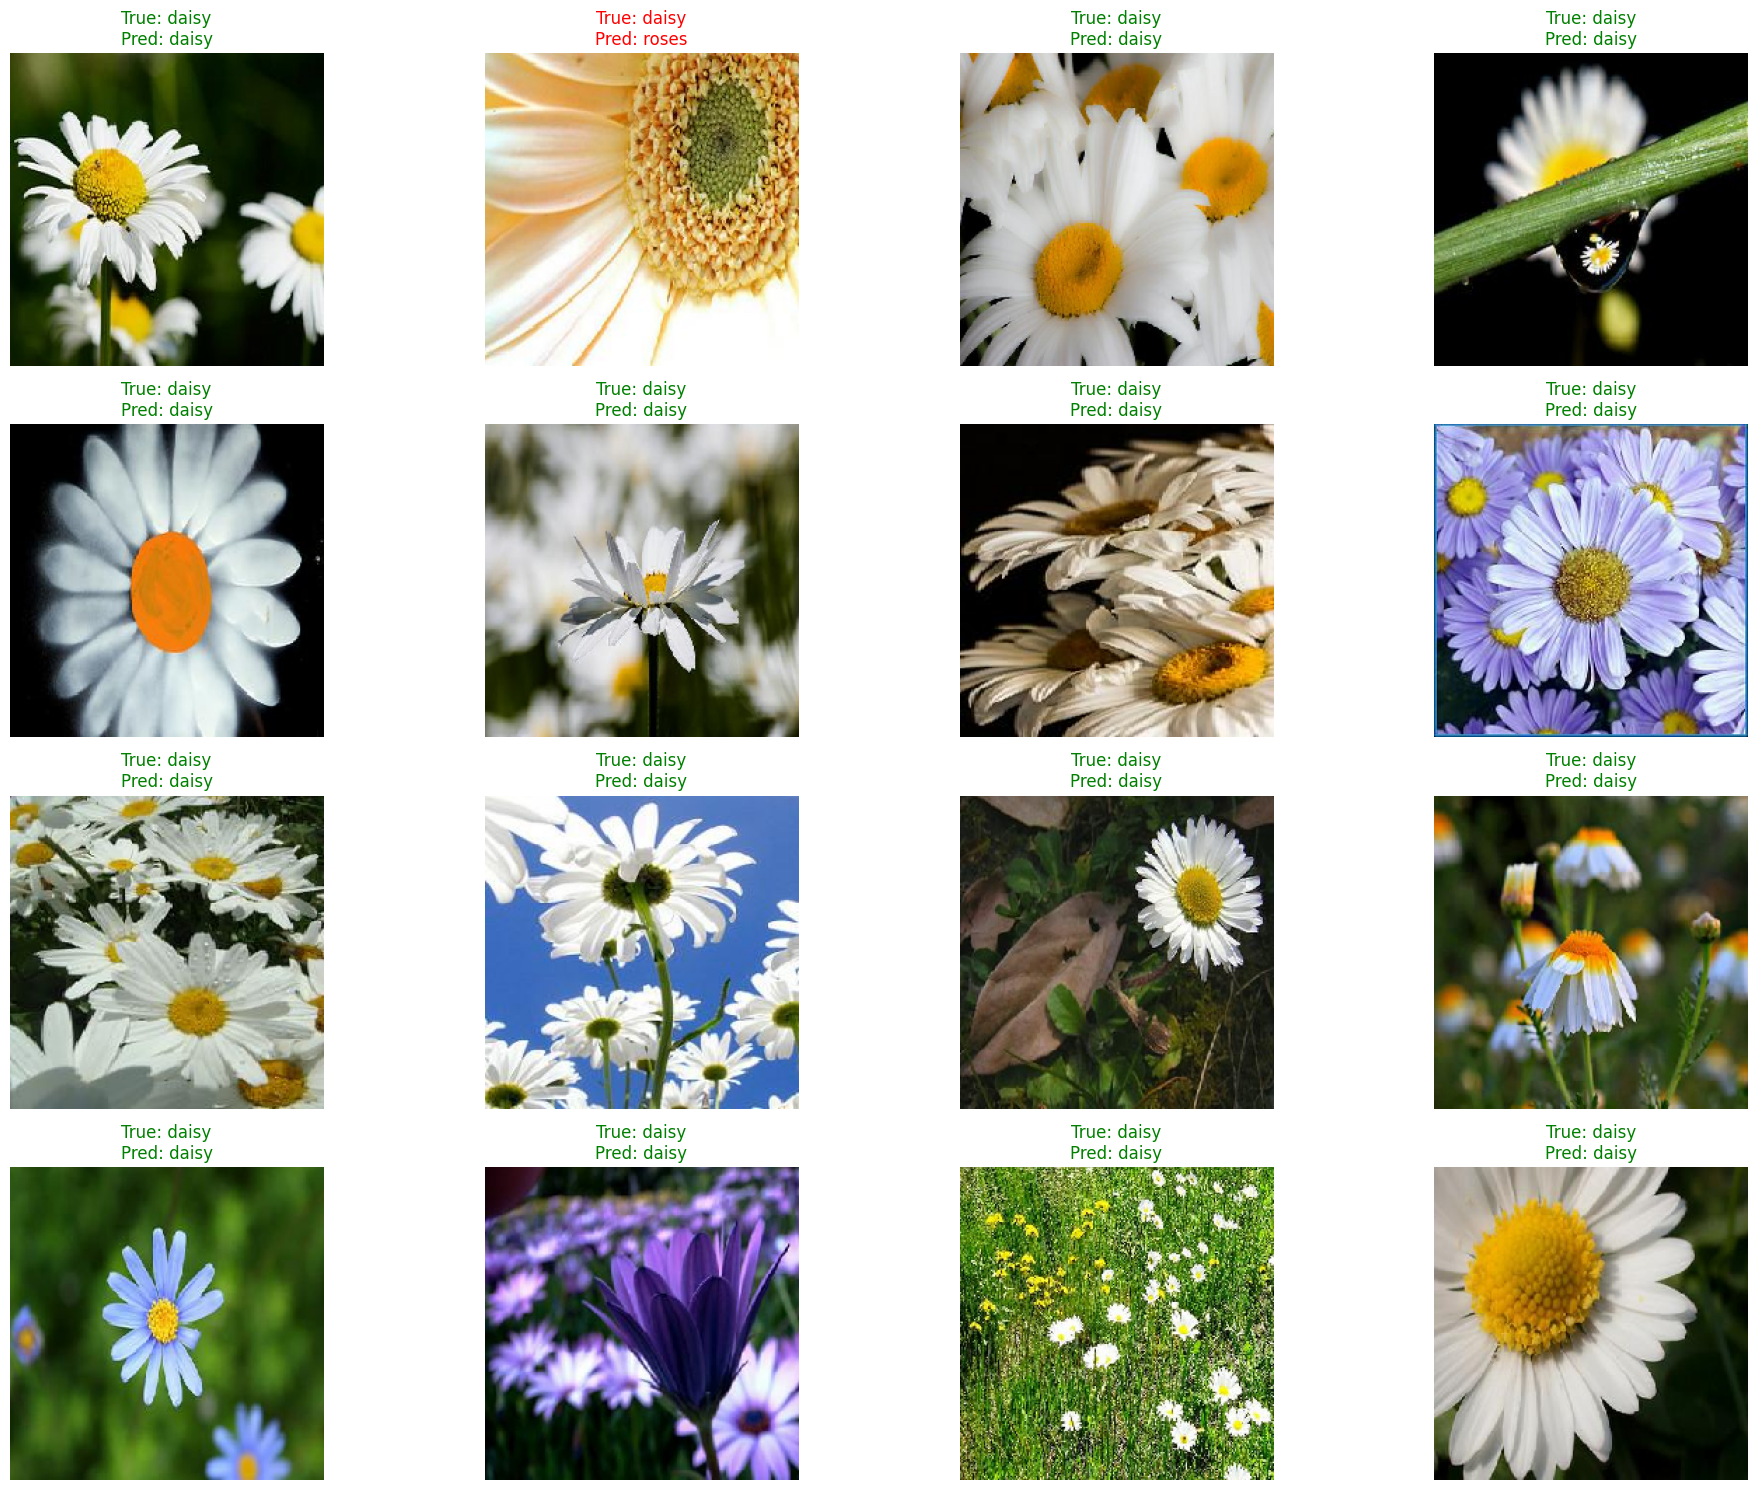

In [37]:
# Step 10: Visualize model predictions
def plot_model_predictions():
    # Reset the generator and predict on a batch
    test_generator.reset()
    test_batch = next(test_generator)
    test_images, test_labels = test_batch

    # Get predictions
    predictions = model.predict(test_images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)

    # Map indices to class names
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Plot images with predictions
    plt.figure(figsize=(20, 15))

    for i in range(min(16, len(test_images))):
        plt.subplot(4, 4, i+1)
        plt.imshow(test_images[i])

        # Color-code the prediction (green for correct, red for wrong)
        color = 'green' if pred_classes[i] == true_classes[i] else 'red'

        plt.title(f"True: {idx_to_class[true_classes[i]]}\nPred: {idx_to_class[pred_classes[i]]}",
                  color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some predictions
plot_model_predictions()

### Model Conversion

In [42]:
# Create a directory for saving models
models_dir = "saved_models"
os.makedirs(models_dir, exist_ok=True)

# 1. First save in Keras format
keras_model_path = os.path.join(models_dir, "model.keras")
model.save(keras_model_path)
print(f"Keras model saved to {keras_model_path}")

# 2. Export to SavedModel format using the tf.saved_model API directly
saved_model_path = os.path.join(models_dir, "saved_model")
tf.saved_model.save(model, saved_model_path)
print(f"SavedModel saved to {saved_model_path}")

Keras model saved to saved_models/model.keras
SavedModel saved to saved_models/saved_model


In [43]:
# Convert to TFLite format
# For the custom CNN model, we don't need a separate simplified version
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model_data = converter.convert()

# Save the TFLite model
tflite_model_path = os.path.join(models_dir, "model.tflite")
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model_data)
print(f"TFLite model saved to {tflite_model_path}")

Saved artifact at '/tmp/tmp8tl0xf34'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134678065427088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678065423824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678101177168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134681115392720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678101176784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678101175824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678065424976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678101176976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678063322064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678063321680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13467810117486

In [44]:
#  Convert to TensorFlow.js format
def convert_to_tfjs():
    tfjs_model_dir = os.path.join(models_dir, "tfjs_model")
    os.makedirs(tfjs_model_dir, exist_ok=True)

    # Convert the model to TFJS format
    try:
        import tensorflowjs as tfjs
        tfjs.converters.save_keras_model(model, tfjs_model_dir)
        print(f"TensorFlow.js model saved to {tfjs_model_dir}")
    except ImportError:
        print("TensorFlow.js converter not installed. Skipping TFJS conversion.")
        print("To install, run: pip install tensorflowjs")

    return tfjs_model_dir

convert_to_tfjs()

failed to lookup keras version from the file,
    this is likely a weight only file
TensorFlow.js model saved to saved_models/tfjs_model


'saved_models/tfjs_model'

## Check if the model exist

In [45]:
def verify_submission_files():
    submission_path = "submission"
    os.makedirs(submission_path, exist_ok=True)

    # Check Keras model
    keras_exists = os.path.exists(os.path.join(models_dir, "model.keras"))

    # Check SavedModel
    saved_model_exists = os.path.exists(os.path.join(models_dir, "saved_model", "saved_model.pb"))

    # Check TFLite
    tflite_exists = os.path.exists(os.path.join(models_dir, "model.tflite"))

    # Check TFJS
    tfjs_exists = os.path.exists(os.path.join(models_dir, "tfjs_model", "model.json"))

    print("\nVerification of model exports:")
    print(f"- Keras model: {'✅' if keras_exists else '❌'}")
    print(f"- SavedModel: {'✅' if saved_model_exists else '❌'}")
    print(f"- TF Lite model: {'✅' if tflite_exists else '❌'}")
    print(f"- TF.js model: {'✅' if tfjs_exists else '❌'}")

# Run verification
verify_submission_files()


Verification of model exports:
- Keras model: ✅
- SavedModel: ✅
- TF Lite model: ✅
- TF.js model: ✅
